In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv('Maternal_Health_Risk_Data_Set.csv')

In [2]:
df['RiskLevel'].value_counts()/df.shape[0]

low risk     0.400394
mid risk     0.331361
high risk    0.268245
Name: RiskLevel, dtype: float64

In [3]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
df.shape

(1014, 7)

Maternal health risk dataset from UCI repo. Three classes, high risk class is a slight minority. Confusion matrix normalized by the row (so that diagonals are recall wrt that row) would be the metric I'll be focussing on.

In [5]:
cols = df.columns.tolist()
cols.remove('RiskLevel')

## Visualizing the Data

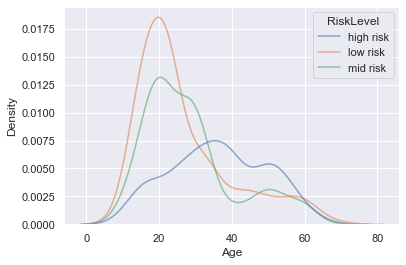

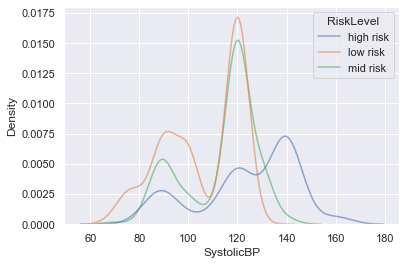

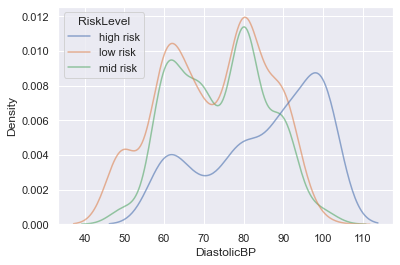

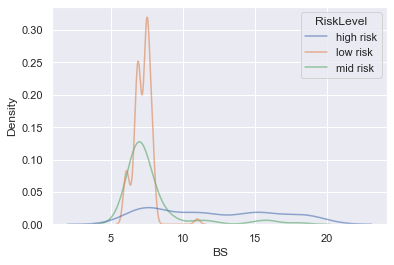

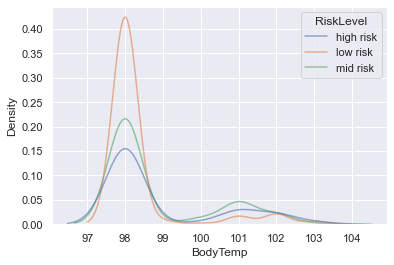

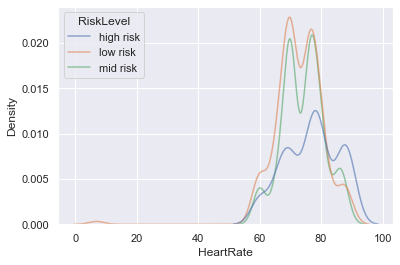

In [6]:
for i in cols:
    sns.kdeplot(data=df,x=i,hue='RiskLevel',alpha=0.6)
    plt.xlabel(i)
    plt.show()

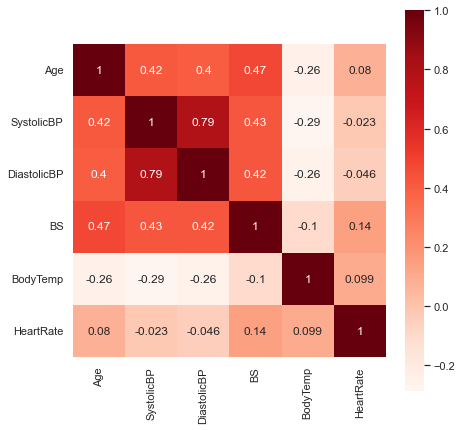

In [7]:
corr = df.drop('RiskLevel',axis=1).corr()
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corr,cmap='Reds',annot=True,square=True,ax=ax)
plt.show()

# Model Fitting

In [25]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(df[cols],df['RiskLevel'],test_size=0.2,random_state=2)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(trainX)

X_train = scaler.transform(trainX)
X_test = scaler.transform(testX)

target_enc = {'low risk':0, 'mid risk':1, 'high risk':2}

y_train = trainY.replace(target_enc)
y_test = testY.replace(target_enc)

In [28]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

In [29]:
classifiers = [LogisticRegression(), SGDClassifier(), GaussianNB(), SVC(), DecisionTreeClassifier(),
               LGBMClassifier(), XGBClassifier(use_label_encoder=False), CatBoostClassifier(verbose=False)]

scores = pd.DataFrame(columns=['Classifier','TestScore','TrainScore','TestConfusionMatrix'])

for i in classifiers:
    i.fit(X_train, y_train)
    y_pred_test = i.predict(X_test)
    scores.loc[len(scores.index)] = [i.__class__.__name__,
                                     accuracy_score(y_test,y_pred_test),i.score(X_train,y_train),
                                     confusion_matrix(y_test,y_pred_test,normalize='true')]

[21:30:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
scores.sort_values(by='TestScore').drop('TestConfusionMatrix',axis=1)

,Classifier,TestScore,TrainScore
0,LogisticRegression,0.610837,0.622688
2,GaussianNB,0.625616,0.593095
1,SGDClassifier,0.635468,0.628853
3,SVC,0.714286,0.717633
4,DecisionTreeClassifier,0.847291,0.921085
5,LGBMClassifier,0.857143,0.921085
7,CatBoostClassifier,0.862069,0.921085
6,XGBClassifier,0.866995,0.921085


Lets look at the confusion matrices of the top 3 classifiers: LGBM, XGBoost and CatBoost

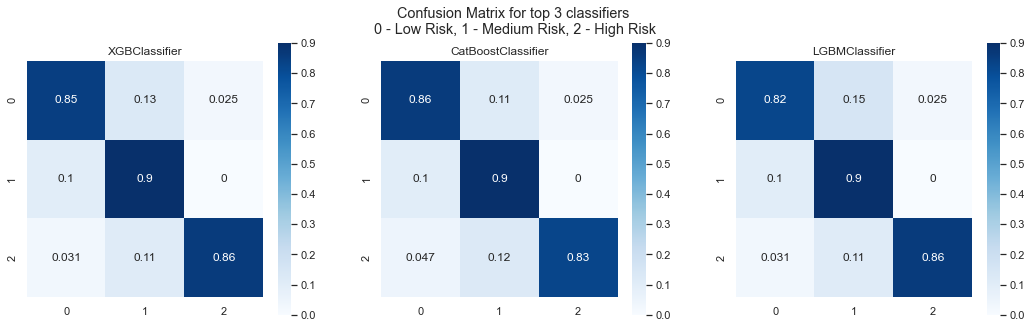

In [33]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Confusion Matrix for top 3 classifiers\n 0 - Low Risk, 1 - Medium Risk, 2 - High Risk')
sns.heatmap(scores['TestConfusionMatrix'].loc[6],square=True,annot=True,cmap='Blues',ax=ax1)
ax1.set_title('XGBClassifier')
sns.heatmap(scores['TestConfusionMatrix'].loc[7],square=True,annot=True,cmap='Blues',ax=ax2)
ax2.set_title('CatBoostClassifier')
sns.heatmap(scores['TestConfusionMatrix'].loc[5],square=True,annot=True,cmap='Blues',ax=ax3)
ax3.set_title('LGBMClassifier')
plt.show()

Again, the confusion matrices are normalized along the rows. The diagonals represent recall score for that row. Performance is pretty even across the board for all classes.